# IMAGE CAPTION GENERATOR

In this project, we developed an Image Caption Generator using deep learning techniques. The aim was to build a model that can generate meaningful textual descriptions for given input images. This project involved collecting a dataset of images and their corresponding captions, training a deep learning model, and integrating it into a web application.

To start, we gathered a dataset of images and their associated captions. Once we have completed the data collection process, we proceeded to build the Image Caption Generator model.
For the deep learning aspect, we utilized convolutional neural networks (CNNs) and recurrent neural networks (RNNs) in combination. CNNs were used to extract meaningful features from the input images, while RNNs, specifically Long Short-Term Memory (LSTM) networks, were employed to generate captions based on the extracted features.

### IMPORTING NECESSARY LIBRARIES

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import cv2 as cv
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import load_model

c:\Users\sansi\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\sansi\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\sansi\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\sansi\anaconda3\envs\tf\lib\site-packages\tensorflow\python\framework\dty

### DATASET 

Here, we will be using the Flickr 8K Dataset. It consists of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations

### EXTRACTING IMAGE FEATURES

To extract image feature, we will be using VGG16, which is a pre-trained model on the ImageNet Dataset for object detection and classification.

In [2]:
# loading vgg16 model
model = VGG16()
# restructuring the model 
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
# we donot require the predicitions, therefore, we donot take the last layer for the output
# printing summary of the model
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
features = {}

data_path = './Flickr8kDataset/Images/'

for img_name in os.listdir(data_path):
    img = load_img(os.path.join(data_path,img_name), target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    # preprocess image for vgg
    img = preprocess_input(img)
    # extract features
    feature = model.predict(img, verbose=0)
    img_id = img_name.split('.')[0]
    # store feature
    features[img_id] = feature

### STORING THE EXTRACTED FEATURES

In [ ]:
# storing features using pickle
pickle_out = open("features.pickle", "wb")
pickle.dump(features, pickle_out, protocol=4)
pickle_out.close()

In [3]:
# loading features from pickle
pickle_in = open("features.pickle", "rb")
features = pickle.load(pickle_in)

### LOADING CAPTIONS DATA

In [4]:
with open ("./Flickr8kDataset/captions.txt") as c:
    next(c) # the first line of the file is not required
    captions = c.read()

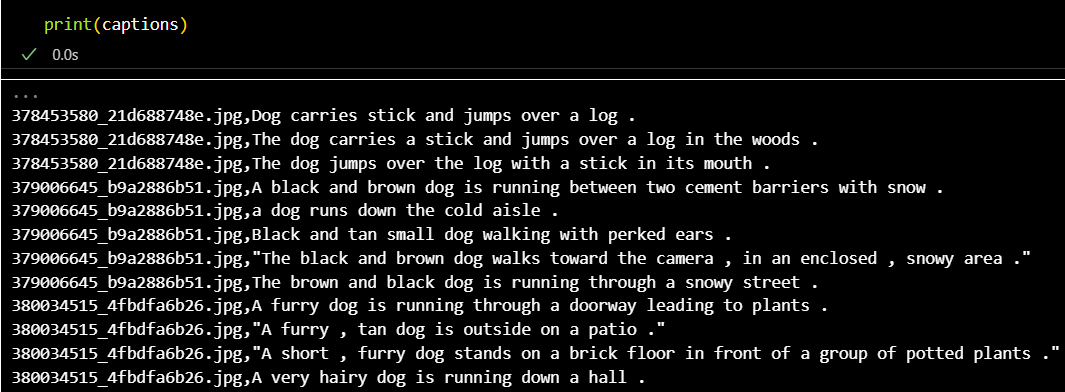
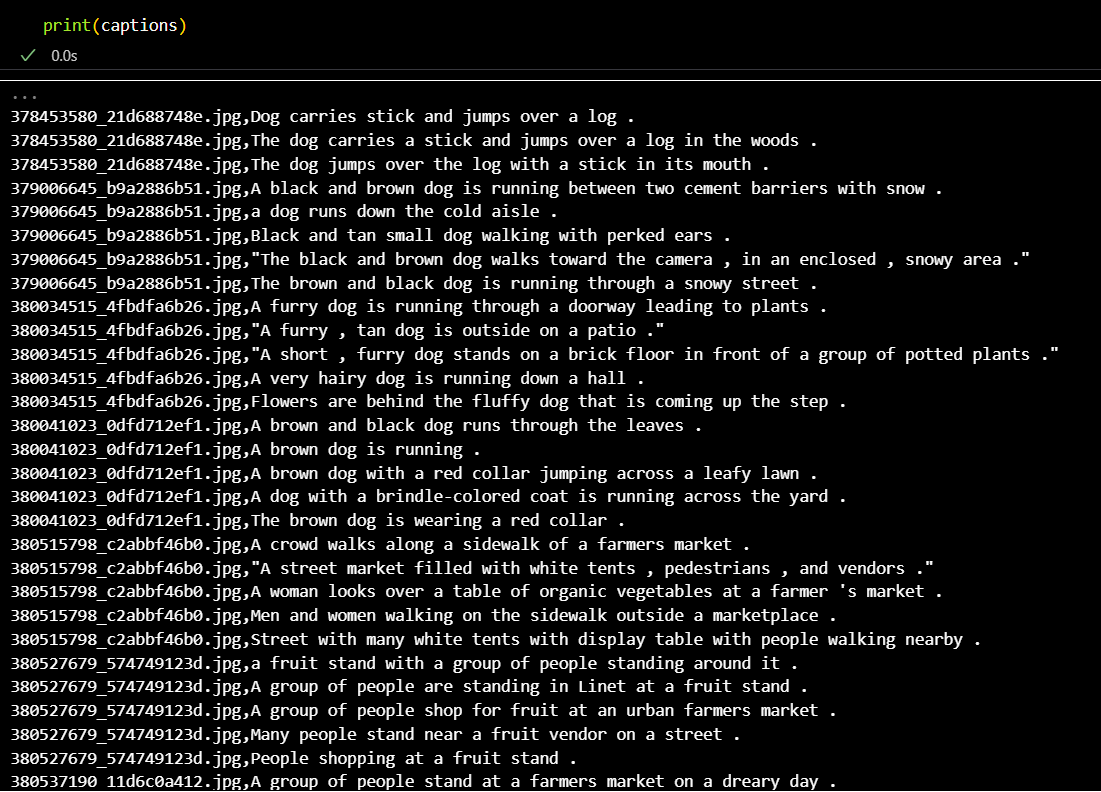

Now, we will create a mapping of image to caption. Since we have 5 captions for every image in the dataset, the mapping for every image will be a list

In [5]:
# an image caption mapping
caption_mapping = {}

for line in captions.split('\n'): #splitting the captions line by line
    # splitting the line into image id and caption
    if len(line) < 2 :
        continue
    caption = line.split(',')
    img_id = caption[0]
    caption = caption[1]
    # removing '.jpg' extension from image id
    img_id = img_id.split('.')[0]
    # create an empty list if it's not present in the mapping
    if img_id not in caption_mapping:
        caption_mapping[img_id] = []
    # append the caption to it's corresponding image id's list
    caption_mapping[img_id].append(caption)

In [6]:
len(caption_mapping)

8091

So, now we have a mapping of image to it's image array and image to it's captions.

A couple stands close at the water 's edge .
The two people stand by a body of water and in front of bushes in fall .
Two people hold each other near a pond .
Two people stand by the water .
Two people stand together on the edge of the water on the grass .


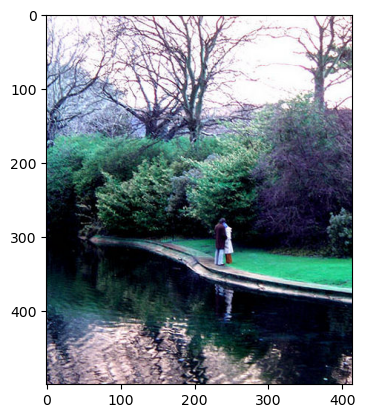

In [7]:
x = cv.imread('./Flickr8kDataset/Images/3637013_c675de7705.jpg')
plt.imshow(x)
for ele in caption_mapping['3637013_c675de7705']:
    print(ele)

### PRE-PROCESSING TEXT DATA

In [8]:
def pre_process_cleaning(mapping):
    # for every image captions in the mapping
    for img_id, captions in mapping.items():
        # for every caption in the list of captions of an image
        for i in range(len(captions)):
            caption = captions[i]
            # convert to lowercase
            caption = caption.lower()
            # deleting digits, special characters and etc.
            caption = caption.replace('[^a-z]', '')
            # deleting additional spaces
            caption = caption.replace('\s+', ' ')
            # adding start and end tags to the caption
            caption = 'start ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' end'
            captions[i] = caption 
            

In [9]:
# before pre_process_cleaning
for caption in caption_mapping['3637013_c675de7705']:
    print(caption)

A couple stands close at the water 's edge .
The two people stand by a body of water and in front of bushes in fall .
Two people hold each other near a pond .
Two people stand by the water .
Two people stand together on the edge of the water on the grass .


In [10]:
pre_process_cleaning(caption_mapping)

In [11]:
# after pre_process_cleaning
for caption in caption_mapping['3637013_c675de7705']:
    print(caption)

start couple stands close at the water 's edge end
start the two people stand by body of water and in front of bushes in fall end
start two people hold each other near pond end
start two people stand by the water end
start two people stand together on the edge of the water on the grass end


Now that we have pre-processed the text, we will now tokenize the text.

In [12]:
all_captions = []

# for every image
for img_id in caption_mapping:
    # for every caption of the image
    for caption in caption_mapping[img_id]:
        all_captions.append(caption)
        
print(len(all_captions))

40455


In [13]:
# Tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

pickle_out = open("tokenizer.pickle", "wb")
pickle.dump(tokenizer, pickle_out, protocol=4)
pickle_out.close()

In [13]:
pickle_in = open("tokenizer.pickle", "rb")
tokenizer = pickle.load(pickle_in)

In [14]:
vocabulary_size = len(tokenizer.word_index) + 1
print(vocabulary_size)

8311


In [15]:
# finding the maximum length of a caption for padding purposes
max_length = max(len(caption.split()) for caption in all_captions)
max_length

31

### TRAIN TEST SPLIT

In [16]:
img_ids = list(caption_mapping.keys())
split = int(len(img_ids) * 0.9) # Taking 90% of the samples for training
train_data = img_ids[:split]
test_data = img_ids[split:]

In [17]:
# create data generator to get data in batch
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## MODEL CREATION

Here we will have 2 inputs, one is the image features and the other one being the captions data. Since the image is processed using VGG16, the input shape of the image features will be the output shape of VGG16 model. We will be using LSTM for the captions data. These two are taken as inputs and the output is a dense layer of 8311 nuerons, since its the vocabulary size and the activation will be softmax and thus, the word with the highest probability will be chosen as the output.

In [108]:
# image features layers
input1 = Input(shape=(4096,))
x = Dropout(0.4)(input1)
x = Dense(256, activation='relu')(x)

# sequence feature layers
input2 = Input(shape=(max_length,))
y = Embedding(vocabulary_size, 256, mask_zero=True)(input2)
y = Dropout(0.4)(y)
y = LSTM(256)(y)

# decoder layers
decoder = add([x, y])
decoder = Dense(256, activation='relu')(decoder)
output = Dense(vocabulary_size, activation='softmax')(decoder)

# model creation
model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

### MODEL PLOT

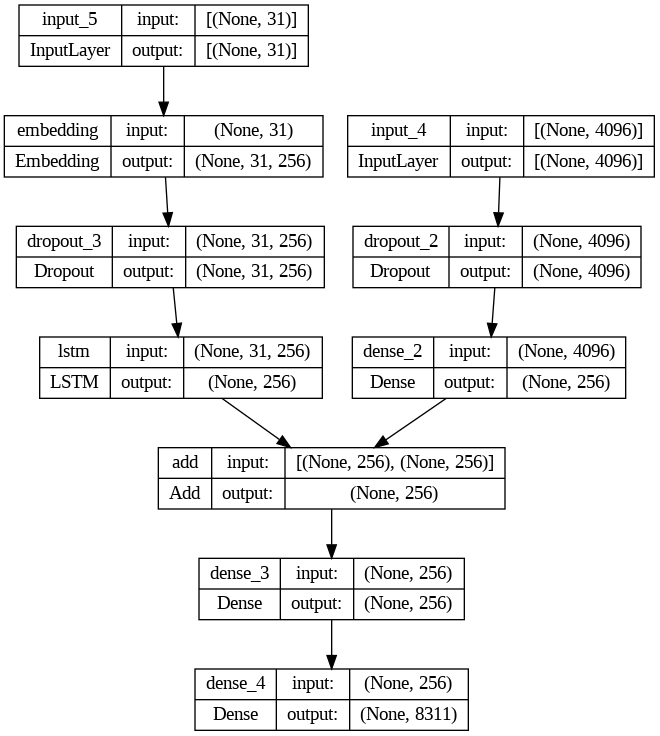

#### TRAINING THE MODEL

In [109]:
epochs = 20
batch_size = 32
steps = len(train_data) // batch_size

for i in range(epochs):
    # creating data generator
    generator = data_generator(train_data, caption_mapping, features, tokenizer, max_length, vocabulary_size, batch_size)
    # fitting for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1) 

227/227 [==============================] - 461s 2s/step - loss: 2.1474


In [110]:
# saving the model
model.save("Image_Caption_Generator.h5")

In [17]:
model=keras.models.load_model("./Image_Caption_Generator.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### GENERATING CAPTIONS FOR IMAGES

In [18]:
# function to find the word given the index
def ind_to_word (index, tokenizer):
    for word, ind in tokenizer.word_index.items():
        if index == ind:
            return word
    return None

In [19]:
# function to predict the caption
def predict_caption(model, image, tokenizer, max_length):
    capt = 'start'
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([capt])[0]
        seq = pad_sequences([seq], max_length)
        y_hat = model.predict([image, seq], verbose=0)
        y_hat = np.argmax(y_hat)
        word = ind_to_word(y_hat, tokenizer)
        if word is None:
            break
        capt += ' ' + word
        if word == 'end':
            break
    return capt

In [20]:
# calculating bleu score
from nltk.translate.bleu_score import corpus_bleu

actual = []
predicted = []

for key in test_data:
    captions = caption_mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))

BLEU-1: 0.531018
BLEU-2: 0.312376


In [20]:
from PIL import Image
import matplotlib.pyplot as plt

In [21]:
# function to generate caption for an image in the dataset
def gen_caption(image_name, data_path = './Flickr8kDataset/Images/' ):
    img_id = image_name.split('.')[0]
    img_path = os.path.join(data_path, image_name)
    image = Image.open(img_path)
    captions = caption_mapping[img_id]
    print("Actual Captions :")
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[img_id], tokenizer, max_length)
    print("Predicted Caption :")
    print(y_pred)
    plt.imshow(image)

Actual Captions :
start couple stands close at the water 's edge end
start the two people stand by body of water and in front of bushes in fall end
start two people hold each other near pond end
start two people stand by the water end
start two people stand together on the edge of the water on the grass end
Predicted Caption :
start two people stand on the water looking at pond end


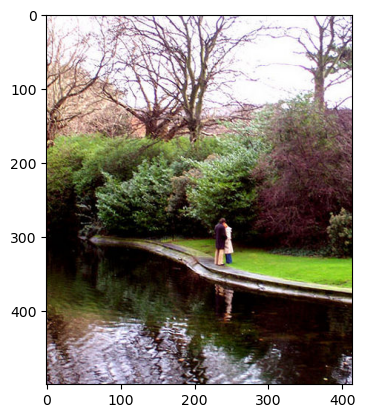

In [36]:
gen_caption("3637013_c675de7705.jpg")

Actual Captions :
start black dog and spotted dog are fighting end
start black dog and tri-colored dog playing with each other on the road end
start black dog and white dog with brown spots are staring at each other in the street end
start two dogs of different breeds looking at each other on the road end
start two dogs on pavement moving toward each other end
Predicted Caption :
start two dogs are playing with each other on the grass end


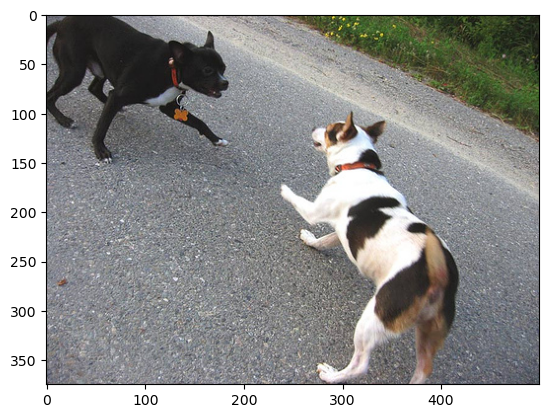

In [22]:
gen_caption("1001773457_577c3a7d70.jpg")

Actual Captions :
start beagle and golden retriever wrestling in the grass end
start two dogs are wrestling in the grass end
start two puppies are playing in the green grass end
start two puppies playing around in the grass end
start two puppies play in the grass end
Predicted Caption :
start two dogs are wrestling in the sand end


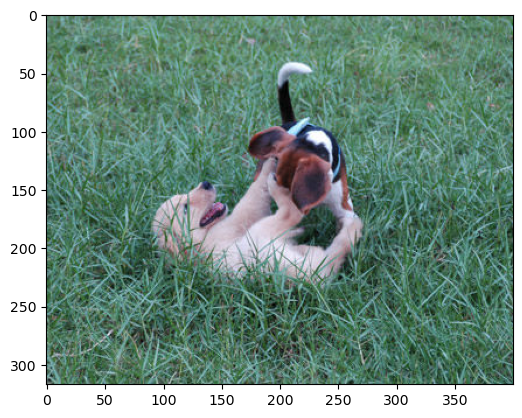

In [37]:
gen_caption("23445819_3a458716c1.jpg")

Actual Captions :
start little girl covered in paint sits in front of painted rainbow with her hands in bowl end
start little girl is sitting in front of large painted rainbow end
start small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it end
start there is girl with pigtails sitting in front of rainbow painting end
start young girl with pigtails painting outside in the grass end
Predicted Caption :
start little girl in dress dress and pigtails painting in the snow end


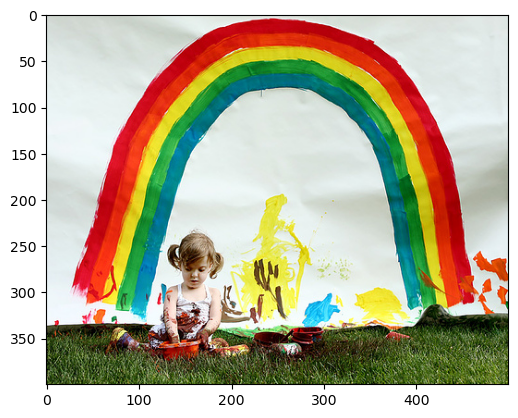

In [23]:
gen_caption("1002674143_1b742ab4b8.jpg")

Actual Captions :
start man in hat is displaying pictures next to skier in blue hat end
start man skis past another man displaying paintings in the snow end
start person wearing skis looking at framed pictures set up in the snow end
start skier looks at framed pictures in the snow next to trees end
start man on skis looking at artwork for sale in the snow end
Predicted Caption :
start two people in snow clothing displaying paintings in the snow end


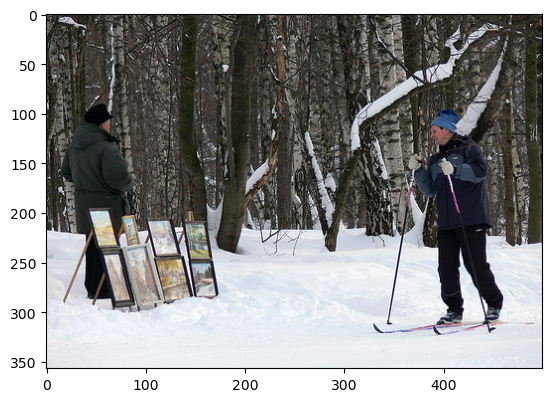

In [24]:
gen_caption("101669240_b2d3e7f17b.jpg")

In [25]:
# loading vgg16 model
vgg_model = VGG16()
# restructuring the model 
vgg_model = Model(inputs = vgg_model.inputs, outputs = vgg_model.layers[-2].output)

In [27]:
def gen_caption_image(data_path):   
    # load the image from file
    image = Image.open(data_path)
    plt.imshow(image)
    img = load_img(data_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    # preprocess image for vgg
    img = preprocess_input(img)
    # extract features
    feature = vgg_model.predict(img, verbose=0)
    # # get image ID
    y_pred = predict_caption(model, feature, tokenizer, max_length)
    print("Predicted Caption :")
    print(y_pred)

#### GENERATING CAPTIONS FOR TEST IMAGES

Predicted Caption :
start two hikers are standing on snowy hill end


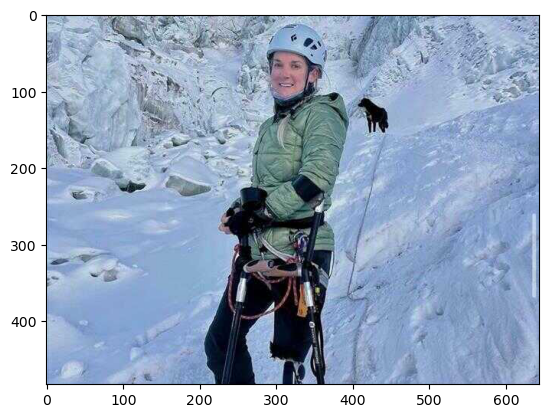

In [28]:
gen_caption_image('./Testing/girl_in_snow.jpg')

Predicted Caption :
start boy in yellow shorts is playing in the ocean end


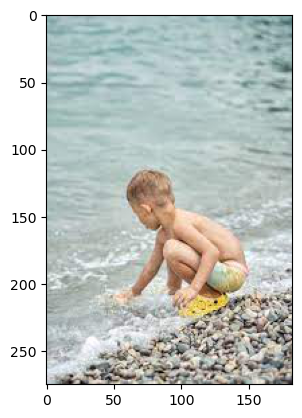

In [39]:
gen_caption_image('./Testing/boy_beach.jpg')